In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import pandas as pd
import glob

In [2]:
autoencoder_model = tf.keras.saving.load_model('autoencoder_model')
classifier = tf.keras.saving.load_model('fake_classifier')
# Create a new model that only includes the encoder part
encoder_model = tf.keras.Model(inputs=autoencoder_model.input, outputs=autoencoder_model.get_layer('dense_14').output)

In [3]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pydub import AudioSegment

def audio_to_mel_spectrogram(audio_file_path, max_length=4*22500, sr=22500, n_mels=256):
    #audio_file_path = audio_file_path if type(audio_file_path) == str else audio_file_path.decode('ASCII')
    #audio_file_path = str(audio_file_path).replace('\\\\', os.sep)
    #audio_file_path = audio_file_path.replace('F:', '/mnt/f').replace('//', '/')
    with open(audio_file_path, 'rb') as fh:
        y, sr = librosa.load(fh, sr=sr)
    
    if len(y) > max_length:
        # If the audio is longer than the maximum length, cut it
        y = y[:max_length]
    elif len(y) < max_length:
        # If the audio is shorter, pad it with zeros
        pad_length = max_length - len(y)
        y = np.pad(y, (0, pad_length), mode='constant')
    
    # Calculate the Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_mels)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    return mel_spectrogram

# Generator function for lazy loading of audio data
def audio_data_generator(audio_files):
    for audio_file in audio_files:
        sample = (audio_to_mel_spectrogram(audio_file) + 80)/80
        yield sample.reshape((1, 128, 176, 1))

In [4]:
# Example usage
spectrogram = next(audio_data_generator(["converted.wav"]))
print(spectrogram.shape)
embedding = encoder_model.predict(spectrogram)
y = classifier.predict(embedding)
y

c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


(1, 128, 176, 1)
1/1 [==============================] - 0s 64ms/step


array([[0.3797141]], dtype=float32)

In [5]:
spectrogram = next(audio_data_generator(["reconstructed_audio.wav"]))
print(spectrogram.shape)
embedding = encoder_model.predict(spectrogram)
y = classifier.predict(embedding)
y

(1, 128, 176, 1)
1/1 [==============================] - 0s 26ms/step


array([[0.5655227]], dtype=float32)

In [7]:
spectrogram = next(audio_data_generator(["recording42.wav"]))
print(spectrogram.shape)
embedding = encoder_model.predict(spectrogram)
y = classifier.predict(embedding)
y

(1, 128, 176, 1)
1/1 [==============================] - 0s 26ms/step


array([[0.3797185]], dtype=float32)

In [8]:
spectrogram = next(audio_data_generator(["recording.wav"]))
print(spectrogram.shape)
embedding = encoder_model.predict(spectrogram)
y = classifier.predict(embedding)
y

(1, 128, 176, 1)
1/1 [==============================] - 0s 28ms/step


array([[0.40134802]], dtype=float32)

In [52]:
spectrogram = next(audio_data_generator(["test/0.wav"]))
print(spectrogram.shape)
embedding_s = encoder_model.predict(spectrogram)
y = classifier.predict(embedding_s)
y

(1, 128, 176, 1)
1/1 [==============================] - 0s 22ms/step


c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


array([[0.72436786]], dtype=float32)

In [43]:
from glob import glob

files = []
for f in glob('test/*'):
    files.append(f)
spectrogram = audio_data_generator(files)
embedding = encoder_model.predict(spectrogram, verbose=-1)
y = classifier.predict(embedding)


      1/Unknown - 0s 56ms/step

c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


65/65 [==============================] - 64s 994ms/step


In [51]:
classifier.fit(embedding, np.array([int(not 'original' in e) for e in files]))

3/3 [==============================] - 0s 5ms/step - loss: 0.3122 - auc: 0.8279 - precision: 0.8769 - recall: 1.0000


In [55]:
auc_r = []
i = 0
for e in files:
    #print(e, y[i], not 'original' in e)
    auc_r.append([y[i][0], int(not 'original' in e)])
    i+=1


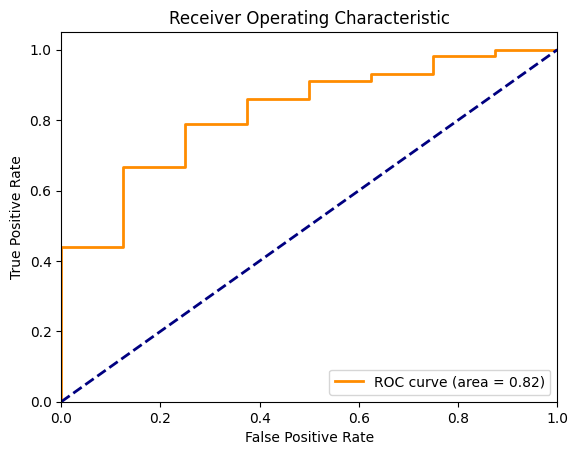

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
import tensorflow as tf

val_y = [i[1] for i in auc_r]
y_pred = [i[0] for i in auc_r]
fpr, tpr, thresholds = roc_curve(val_y, y_pred)

# Calculate the ROC-AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC-AUC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()